In [335]:
%store -r Final_Data_Set_Nor
%store -r Borrower_Emb_Dict
%store -r EN_Des
%store -r training_labels
%store -r Sector_Des
%store -r sector_list

import dgl
import numpy as np
import networkx as nx
import torch as T
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from sklearn.manifold import TSNE
import time
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,rc={"lines.linewidth": 2.5})

import nbimporter
from Proof_of_Concept_KG import Print_Cluster
from NDE_Time_Series_Problem import fashion_scatter
import embedding_retriever as er

from sklearn.metrics.cluster import normalized_mutual_info_score


In [336]:
from numpy import linalg as LA
x = [[1,1],[2,2]]
w, v = LA.eig(np.array(x))
print(w,v,'\n')
maxcol = list(w).index(max(w))
eigenvect = v[:,maxcol]
print(maxcol,eigenvect)

[0. 3.] [[-0.70710678 -0.4472136 ]
 [ 0.70710678 -0.89442719]] 

1 [-0.4472136  -0.89442719]


In [337]:
for i in Final_Data_Set_Nor.items():
    ID,data = i
    R_Att = T.tensor([data['Revenue']])
    E_Att = T.tensor([data['EBITDA']])
    NDE_Att = T.tensor([data['NDE']])
    TDE_Att = T.tensor([data['TDE']])
    Des_Att = T.tensor(data['Description Embedding'])
    Sec_Att = T.tensor(data['Description Embedding'])
    break
    
for i in Final_Data_Set_Nor.items():
    ID,data = i
    R_Att = T.cat((R_Att,T.tensor([data['Revenue']])),0)
    E_Att = T.cat((E_Att,T.tensor([data['EBITDA']])),0)
    NDE_Att = T.cat((NDE_Att,T.tensor([data['NDE']])),0)
    TDE_Att = T.cat((TDE_Att,T.tensor([data['TDE']])),0)
    Des_Att = T.cat((Des_Att,T.tensor(data['Description Embedding'])),0)
    Sec_Att = T.cat((Sec_Att,T.tensor([Sector_Des[data['Sector'][1:-1]]['Sector Des Emb']])),0)
    
sector_labels = []
for i in Sector_Des.items():
    ID,Emb = i
    sector_description = T.cat((sector_description,T.tensor([Emb['Sector Des Emb']])),0)
    
    

R_Att = R_Att[1:]
E_Att = E_Att[1:]
NDE_Att = NDE_Att[1:]
TDE_Att = TDE_Att[1:]
Des_Att = Des_Att[1:]
print(Des_Att.shape)
Sec_Att = Sec_Att[1:]
print(Sec_Att.shape)

torch.Size([756, 768])
torch.Size([756, 768])


In [340]:
def my_agg_func(tensors, dsttype, dim):
    p = len(tensors)
    a = 60
    w = 1/p

    X = []
    for i in range(p):
        l = []
        for j in range(p):
            if i == j:
                b = w
            else:
                b = a

            m1 = T.t(tensors[i]).detach().numpy()
            m2 = tensors[j].detach().numpy()
            
            shape = np.shape(np.matmul(m1,m2))
            padded_array = np.zeros((768, 768))
            padded_array[:shape[0],:shape[1]] = np.round(b*np.matmul(m1,m2),2)

            l.append(padded_array)
        X.append(np.concatenate(l,1))
    
    X = np.concatenate(X,0)

    w, v = LA.eig(X)
#     print('E-value:', w.shape)
#     print('E-vector:',v.shape)
    
    W = w.copy()
    W.sort()
    W = W[::-1]
    top_ind = []
    for j in W[:dim]:
        top_ind.append(np.where(w == j)[0][0])
    #print(top_ind)
    
    Phi = 0
    eigenvect = []
    for i in top_ind:
        eigenvect.append(v[:,i])
    eigenvect = np.array(eigenvect)
    #print(eigenvect.shape)
    
    pro_vec = []
    n = 768
    for i in range(p):
        shape = tensors[i].shape
        V = eigenvect[: , n*i : n*(i+1)][: , 0:shape[1]]
        #print(V.shape)
        pro_vec.append(V)

    #print(pro_vec)
    
    Phi = 0
    for i in range(p):
        Phi += np.matmul(tensors[i].detach().numpy(),np.transpose(pro_vec[i]))
    Phi = Phi/p
        
    
    return Phi

Emb = my_agg_func([R_Att,E_Att,NDE_Att,TDE_Att,Des_Att],'borrower',12)



Cluster  0 of size  247
[0.5, 0.5, 0.5, 0.5, 0.5] [0, 0, 0, 0, 0]
[0.5, 0.5, 0.7, 0.5, 0.5] [0, 0, 0.6, 0, 0]
[0.1, 0.1, 0.1, 0.1, 0.1] [0.1, 0.1, 0, 0, 0]
[0.2, 0.4, 0.3, 0.3, 0.1] [0, 0, 0.1, 0, 0]
[0.3, 0.3, 0.3, 0.3, 0.3] [0.1, 0.1, 0.1, 0.2, 0.1]
[0.5, 0.5, 0.3, 0.3, 0.3] [0, 0, 0, 0.2, 0.1]


Cluster  1 of size  320
[0.5, 0.5, 0.5, 0.4, 0.4] [0.1, 0.3, 0.1, 0, 0]
[0.5, 0.4, 0.3, 0.2, 0.2] [0, 0, 0, 0, 0]
[0.2, 0.2, 0.1, 0.1, 0.1] [0, 0, 0, 0, 0]
[0.1, 0.1, 0.1, 0.1, 0.1] [0, 0, 0, 0, 0]
[0.7, 0.7, 0.7, 0.7, 0.7] [0.7, 0.6, 0.6, 0.5, 0.5]
[0.1, 0.1, 0.1, 0.1, 0.1] [0, 0, 0, 0, 0]


Cluster  2 of size  189
[0.6, 0.6, 0.6, 0.6, 0.5] [0.5, 0.6, 0.6, 0.5, 0]
[0.3, 0.3, 0.3, 0.3, 0.3] [0.1, 0.1, 0.1, 0.1, 0.1]
[0.5, 0.5, 0.4, 0.3, 0.3] [0.5, 0.5, 0.3, 0.3, 0.3]
[0.3, 0.3, 0.3, 0.3, 0.3] [0.3, 0.2, 0.2, 0.3, 0.3]
[0.1, 0.1, 0.1, 0.1, 0.1] [0.1, 0.1, 0, 0, 0]
[0.1, 0.1, 0.1, 0.1, 0.1] [0, 0.1, 0, 0, 0]


Avg Node Cluster Distance of Cluster  0  is  9.8806
Cluster  0  Center  [ 5.6743555 

0.39381487643763313

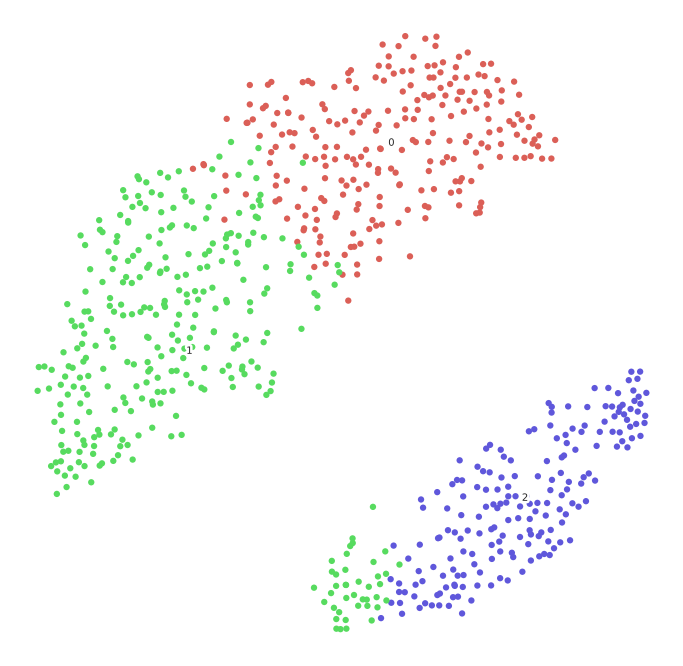

In [341]:
X = Emb
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

def Print_Cluster(clusters,kmeans_labels):
    
    for i in range(clusters):

        cluster = np.where(kmeans_labels == i)[0]
        
        N = 0
        if len(cluster) < 5:
            l_N = len(cluster)
        else:
            l_N = 5
            
        n = 0
        print("Cluster ",i, "of size ", len(cluster))
        for i in Final_Data_Set_Nor.items():
            ID,data = i

            if (n in cluster) and (N <= l_N):
                print(data['Revenue'],data['EBITDA'])#,data['Revenue'],data['EBITDA'],data['NDE'], data['TDE'])
                #print(EN_Des[ID]['Description'],"\n")
                N += 1
            elif N > l_N:
                print("\n")
                break
            n += 1

Print_Cluster(3,kmeans.labels_)
fashion_tsne = TSNE(random_state=123).fit_transform(X)
fashion_scatter(fashion_tsne, kmeans.labels_)

normalized_mutual_info_score(sector_list, kmeans.labels_)

In [333]:
embedder = er.EmbeddingRetriever()

B_R = T.tensor([[0.0,0.0,0.0,0.0,0.0],
                [0.0,0.0,0.0,0.0,0.0],
                [0.5,0.5,0.5,0.5,0.5],
                [0.9,0.9,0.9,0.9,0.9],
                [0.3,0.3,0.3,0.3,0.3]])

B_Des = T.tensor(np.round(embedder.get_bert_embedding(Sector_Des['511210']['Sector Des']),2))
B_Des = T.cat((B_Des,T.tensor(np.round(embedder.get_bert_embedding(Sector_Des['2111']['Sector Des']),2))),0)
B_Des = T.cat((B_Des,T.tensor(np.round(embedder.get_bert_embedding(Sector_Des['511210']['Sector Des']),2))),0)
B_Des = T.cat((B_Des,T.tensor(np.round(embedder.get_bert_embedding(Sector_Des['511210']['Sector Des']),2))),0)
B_Des = T.cat((B_Des,T.tensor(np.round(embedder.get_bert_embedding(Sector_Des['2111']['Sector Des']),2))),0)

Emb_X = my_agg_func([B_R,B_Des],'borrower',10)


In [334]:
print(np.round(np.real(Emb_X),6))

[[ 5.923993e+00 -1.055228e+00  4.900000e-05  7.900000e-05  2.600000e-05
   3.200000e-05 -1.200000e-05  8.800000e-05 -2.600000e-05  3.000000e-05]
 [ 7.285756e+00  4.879563e+00 -2.310000e-04 -3.710000e-04 -1.230000e-04
  -1.490000e-04  5.400000e-05 -4.110000e-04  1.220000e-04 -1.390000e-04]
 [ 6.298893e+00 -1.075547e+00  5.100000e-05  8.100000e-05  2.600000e-05
   3.200000e-05 -1.200000e-05  9.000000e-05 -2.600000e-05  3.100000e-05]
 [ 6.598813e+00 -1.091803e+00  5.200000e-05  8.300000e-05  2.500000e-05
   3.300000e-05 -1.200000e-05  9.100000e-05 -2.700000e-05  3.200000e-05]
 [ 7.510696e+00  4.867371e+00 -2.300000e-04 -3.700000e-04 -1.240000e-04
  -1.480000e-04  5.400000e-05 -4.100000e-04  1.210000e-04 -1.390000e-04]]


In [ ]:
# Emb_X = np.real(Emb_X)
# kmeans = KMeans(n_clusters=4, random_state=0).fit(Emb_X)

# fashion_tsne = TSNE(random_state=123).fit_transform(Emb_X)
# fashion_scatter(fashion_tsne, kmeans.labels_)